In [1]:
import random
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
from skimage.transform import ProjectiveTransform
from skimage.transform import warp

from PIL import Image
import scipy

import scipy.ndimage
from scipy.signal import medfilt2d
%matplotlib inline

In [42]:
def read_image(IMG_NAME):
    img = cv2.imread('data/' + IMG_NAME)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray_img

def read_rgbimage(IMG_NAME):
    img = cv2.imread('data/' + IMG_NAME)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    return img

In [3]:
# Read image and convert to gray
img1 = read_image('left.jpg')
img2 = read_image('right.jpg')


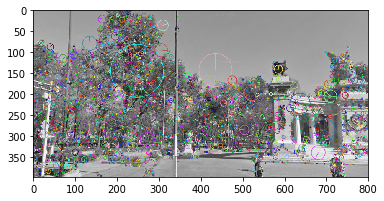

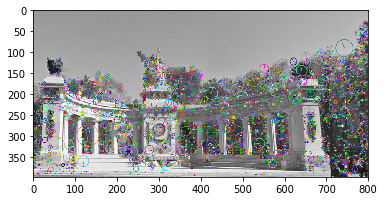

In [4]:
# Sift detection and extraction
def sift_function(img):
    # Sift
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    # Draw points
    img_copy = img
    img = cv2.drawKeypoints(img, kp, img_copy , flags=4)   
    plt.imshow(img)
    plt.show()
    return kp, des

kp1, descrip1 = sift_function(img1)
kp2, descrip2 = sift_function(img2)

In [60]:
def matches(threshold, kp1, kp2, dsp1, dsp2):
    dist = scipy.spatial.distance.cdist(dsp1, dsp2, 'sqeuclidean')
    index1 = np.where(dist < threshold)[0]
    index2 = np.where(dist < threshold)[1]

    # Find the coordinates
    coord1 = []
    coord2 = []
    for i in index1:
        coord1.append(kp1[i].pt)
    for j in index2:
        coord2.append(kp2[j].pt)
#     print(coord1)
    match_coords = np.hstack((coord1, coord2))
    return match_coords

# Select pair below a threshold
match_threshold = 30000

match_coord = matches(match_threshold, kp1, kp2, descrip1, descrip2)
# print(match_coord)

In [65]:
# RANSAC
def RANSAC(matches, iterations, threshold):
    
    # Initialize the homography
    num_of_samples = 4
    num_of_matches = matches.shape[0]
#     n = 0
    max_num_inliers = 0
    num_of_inliers = 0
    final_H = 0
    residual= 0
    inliers_container = np.empty((1,4))
#     match = np.empty((1,4))
    
    for n in range(iterations):
        # four matches to initialize the homography
        
        index = random.sample(range(num_of_matches), num_of_samples)
        A = []
        for i in range(num_of_samples):
            match = (matches[index[i], :]).ravel()
            xT = np.array([[match[0], match[1], 1]])
            temp_mat_1 = np.array([0*xT, 1*xT, -xT*match[3]]).ravel()
            temp_mat_2 = np.array([1*xT, 0*xT, -xT*match[2]]).ravel()
            temp_mat = np.vstack((temp_mat_1, temp_mat_2))
            A.append(temp_mat)

        # Homography
        reformat_A = np.reshape(np.array(A),(-1,9))
        u, s, vh = np.linalg.svd(reformat_A)
        h = vh[len(vh)-1]
        H = np.reshape(h, (3, 3))
        H = H / H[2,2]
            
        inliers = []
        
        
        pts1 = np.hstack((matches[:, 0:2], np.ones((num_of_matches, 1))))

        pts2 = matches[:, 2:4]
        p1_transform = []
        for i in range(num_of_matches):
            
            temp = np.dot(H, pts1[i])
            # Homo transfer
            p1_transform.append((temp/temp[2])[0:2])
            
        p1_transform = np.array(p1_transform)
        dist = np.linalg.norm(pts2 - p1_transform, axis =1) **2

        # Set threshold
        
        temp_index = np.where(dist < threshold)[0]
        inliers = matches[temp_index]
        num_of_inliers = len(inliers)
        
        # update
        if num_of_inliers > max_num_inliers:
            final_inliers = inliers.copy()
            max_num_inliers = num_of_inliers
            final_H = H.copy()
            residual = sum(dist[temp_index]) / max_num_inliers
#             print(residual)
#         n += 1
    
    
# #     print((final_inliers))
#     A = []
#     for i in range(final_inliers.shape[0]):
#         match = (final_inliers[i, :]).ravel()
#         xT = np.array([[match[0], match[1], 1]])
#         temp_mat_1 = np.array([0*xT, 1*xT, -xT*match[3]]).ravel()
#         temp_mat_2 = np.array([1*xT, 0*xT, -xT*match[2]]).ravel()
#         temp_mat = np.vstack((temp_mat_1, temp_mat_2))
#         A.append(temp_mat)

#     # Homography
#     reformat_A = np.reshape(np.array(A),(-1,9))
# #     print(reformat_A.shape)
#     u, s, vh = np.linalg.svd(reformat_A)
#     h = vh[len(vh)-1]
#     H = np.reshape(h, (3, 3))
#     final_H = H / H[2,2]
    
    return final_inliers, final_H, residual

inliers, H, residual = RANSAC(match_coord, 5000, 300)
print(inliers.shape)
print(residual)

(184, 4)
85.9520105086805


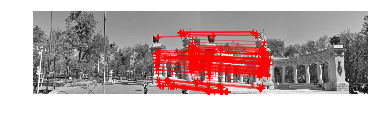

In [66]:
def plot_inlier_matches(inliers, IMG_NAME1, IMG_NAME2):
    I1 = Image.open('data/' + IMG_NAME1).convert('L')
    I2 = Image.open('data/' + IMG_NAME2).convert('L')
    I3 = np.zeros((I1.size[1], I1.size[0]*2))
    I3[:,:I1.size[0]] = I1
    I3[:,I1.size[0]:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(float), cmap='gray')
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2]+I1.size[0], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2]+I1.size[0]],[inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    plt.axis('off')
    plt.savefig('inlier_matches_1.jpg')
    plt.show()

plot_inlier_matches(inliers, 'left.jpg', 'right.jpg')


In [67]:
# Normalized image
imgl = read_rgbimage('left.jpg')
imgr = read_rgbimage('right.jpg')

In [68]:
def warp_images(image0, image1, transform):
    r, c = image1.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = skimage.transform.SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

#     overlap = (image0_ != -1.0 ).astype(int) + (image1_ != -1.0).astype(int)
#     overlap += (overlap < 1).astype(int)
#     merged = (image0_zeros+image1_zeros)/overlap
    temp_overlap = (image1_ == -1.0).astype(int)
    merged = image1_ + image0_ * temp_overlap

    im = Image.fromarray((255*merged).astype('uint8'), mode='RGB')
    im.save('stitched_images1.jpg')
    im.show()


# transform = skimage.transform.ProjectiveTransform(np.linalg.inv(H))

transform = skimage.transform.ProjectiveTransform(H)
stiched = warp_images(imgr, imgl, transform)

